## Compare how the elevation and tides are changing.

In [4]:
#General libraries DEM Bathymetry
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patheffects as pe
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

#General libraries HEC-RAS
import h5py
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import matplotlib.dates as mdates

Cross Sections locations

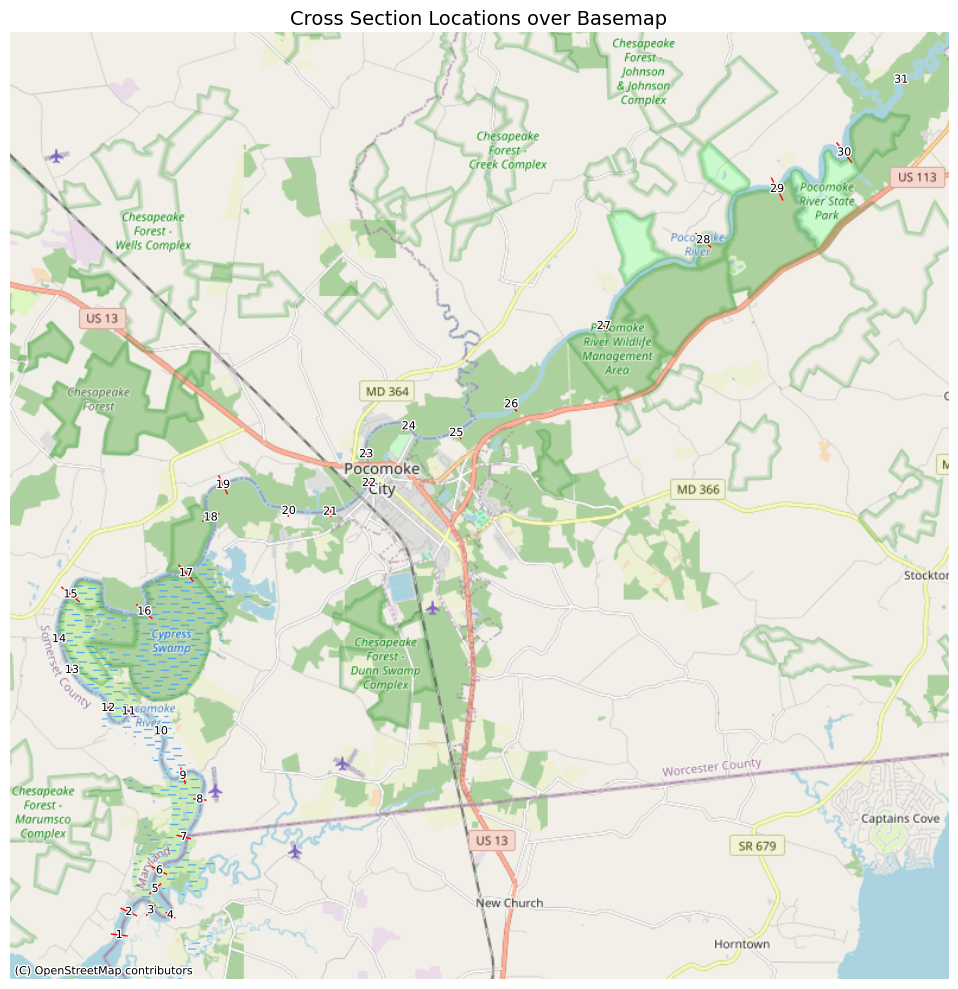

In [140]:
#Load your shapefile
lines_gdf = gpd.read_file(r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Cross.shp")

#Convert to Web Mercator (required for basemap tiles)
lines_gdf = lines_gdf.to_crs(epsg=3857)

#Plot
fig, ax = plt.subplots(figsize=(12, 10))
lines_gdf.plot(ax=ax, edgecolor='red', linewidth=1)

# Label each cross-section
for idx, row in lines_gdf.iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    ax.text(x, y, str(idx + 1), fontsize=8, ha='center', va='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='white')])

# Add basemap (OpenStreetMap by default)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Format
ax.set_title("Cross Section Locations over Basemap", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


## Results DEM before changes


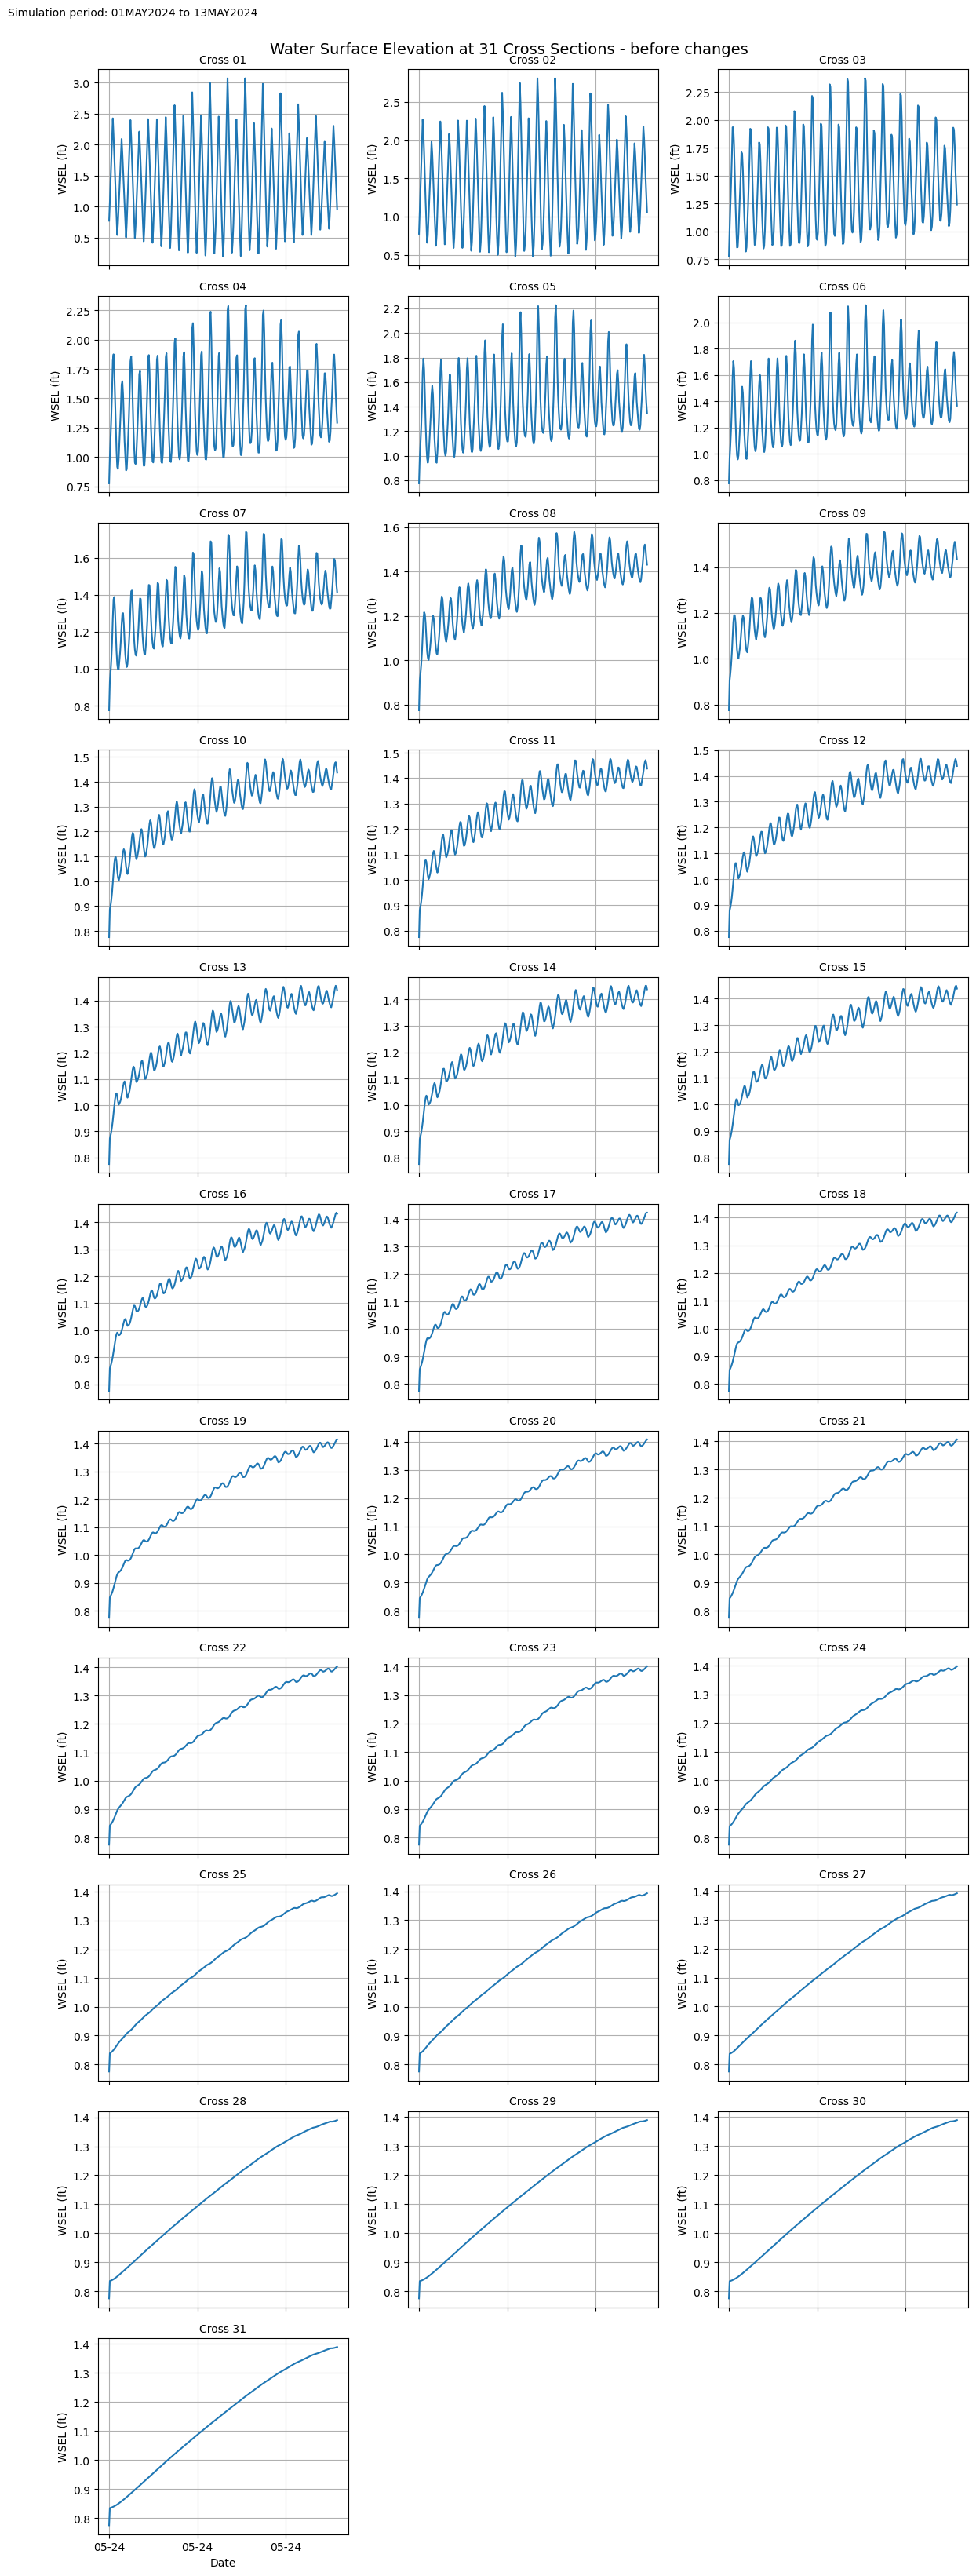

In [3]:
## Tides Simulation (WSEL) at 31 cross sections (DEM without bathymetry)
# FILES INPUTS
hdf_path = r'C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\HDF\v5.p69.hdf'
cell_ids = [628120, 627951, 627921, 628029, 627746, 627684, 627618, 627572, 627530, 627472, 627396, 627381, 635980, 635128, 636050, 635000, 634940, 627311, 634847, 636360, 694557, 845840, 827923, 814408, 660900, 647501, 634688, 634563, 636676, 627066, 634263]  # Replace with your actual cell IDs

# OPEN HDF FILE
with h5py.File(hdf_path, 'r') as f:
    # 1. Get time info
    time_minutes = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time'][:]
    start_str = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time Date Stamp'][0].decode()
    start_datetime = datetime.strptime(start_str, '%d%b%Y %H:%M:%S')
    time_index = [start_datetime + timedelta(minutes=float(t)) for t in time_minutes]

    # 2. Get full water surface matrix (time_steps x num_cells)
    ws_all = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/VA20230620195713/Water Surface'][:]

    # 3. Get all cell minimum elevations
    z_all = f['/Geometry/2D Flow Areas/VA20230620195713/Cells Minimum Elevation'][:]

    # 4. Build WSEL  dataframe
    wsel_data = {}
    for cid in cell_ids:
        ws = ws_all[:, cid]
        wsel_data[f'Cell_{cid}'] = ws

# CREATE FINAL DATAFRAME
wsel_df = pd.DataFrame(wsel_data, index=pd.to_datetime(time_index))
wsel_df.index.name = 'Datetime'


#Mapping Cell ID → Cross Section Name
cell_to_cross = {
    628120: "Cross 01",
    627951: "Cross 02",
    627921: "Cross 03",
    628029: "Cross 04",
    627746: "Cross 05",
    627684: "Cross 06",
    627618: "Cross 07",
    627572: "Cross 08",
    627530: "Cross 09",
    627472: "Cross 10",
    627396: "Cross 11",
    627381: "Cross 12",
    635980: "Cross 13",
    635128: "Cross 14",
    636050: "Cross 15",
    635000: "Cross 16",
    634940: "Cross 17",
    627311: "Cross 18",
    634847: "Cross 19",
    636360: "Cross 20",
    694557: "Cross 21",
    845840: "Cross 22",
    827923: "Cross 23",
    814408: "Cross 24",
    660900: "Cross 25",
    647501: "Cross 26",
    634688: "Cross 27",
    634563: "Cross 28",
    636676: "Cross 29",
    627066: "Cross 30",
    634263: "Cross 31"
}

#Prepare Grid
num_cells = len(wsel_df.columns)
cols = 3  # Number of columns for subplots
rows = math.ceil(num_cells / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True)
axes = axes.flatten()

#Plot with Custom Titles
for i, col in enumerate(wsel_df.columns):
    cell_id = int(col.replace("Cell_", ""))  # e.g., "Cell_627951" → 627951
    cross_name = cell_to_cross.get(cell_id, col)  # fallback to ID if not found

    ax = axes[i]
    ax.plot(wsel_df.index, wsel_df[col])
    ax.set_title(cross_name, fontsize=10)
    ax.set_ylabel("WSEL (ft)")
    ax.grid(True)

    # Format x-axis
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))

    if i >= (rows - 1) * cols:
        ax.set_xlabel("Date")

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Water Surface Elevation at 31 Cross Sections - before changes", fontsize=14)
fig.text(0.1, 0.99, "Simulation period: 01MAY2024 to 13MAY2024", ha='center', fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

#Tides simulation 
General information: 

-- Gauge 8571097 Shelltown, MD, Original datum is MLLW
Link: https://tidesandcurrents.noaa.gov/noaatidepredictions.html?id=8571097&units=standard&bdate=20240501&edate=20240514&timezone=LST/LDT&clock=24hour&datum=MLLW&interval=hilo&action=dailychart

-- Convert the Datum to NAVD88: + 1.17 (Link reference: https://tidesandcurrents.noaa.gov/datums.html?datum=MLLW&units=0&epoch=0&id=8571359&name=Snow+Hill&state=MD)

Period: 01MAY2024 13MAY2024

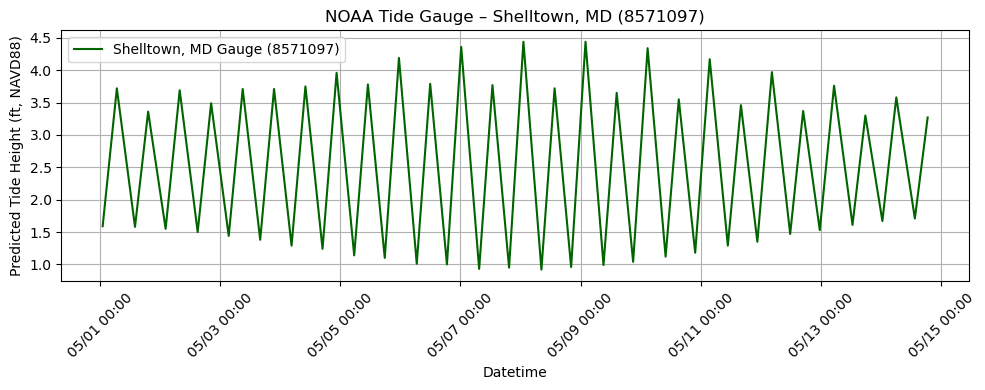

In [ ]:
#Gauge plot -- Gauge 8571097 Shelltown, MD
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === File path ===
excel_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\Book2.xlsx"

# === Load Sheet2
df = pd.read_excel(excel_path, sheet_name="Sheet2")

# === Clean column names and rename
df.columns = df.columns.str.strip().str.replace('\n', ' ', regex=True)
df.rename(columns={
    df.columns[0]: "Date",
    df.columns[1]: "Time",
    df.columns[2]: "Predicted"
}, inplace=True)

# === Combine Date + Time into single datetime column
df["Datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str), errors='coerce')
df = df.dropna(subset=["Datetime"])

# === Plot with full datetime labels
plt.figure(figsize=(10, 4))
plt.plot(df["Datetime"], df["Predicted"], label="Shelltown, MD Gauge (8571097)", color='darkgreen')
plt.title("NOAA Tide Gauge – Shelltown, MD (8571097)")
plt.xlabel("Datetime")
plt.ylabel("Predicted Tide Height (ft, NAVD88)")
plt.grid(True)

# Format x-axis to show both date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.legend()
plt.show()


In [107]:
## Note: The time series have a irregular interval. I used average to upload in HECRAS.

## Results DEM + Bathymetry version 14

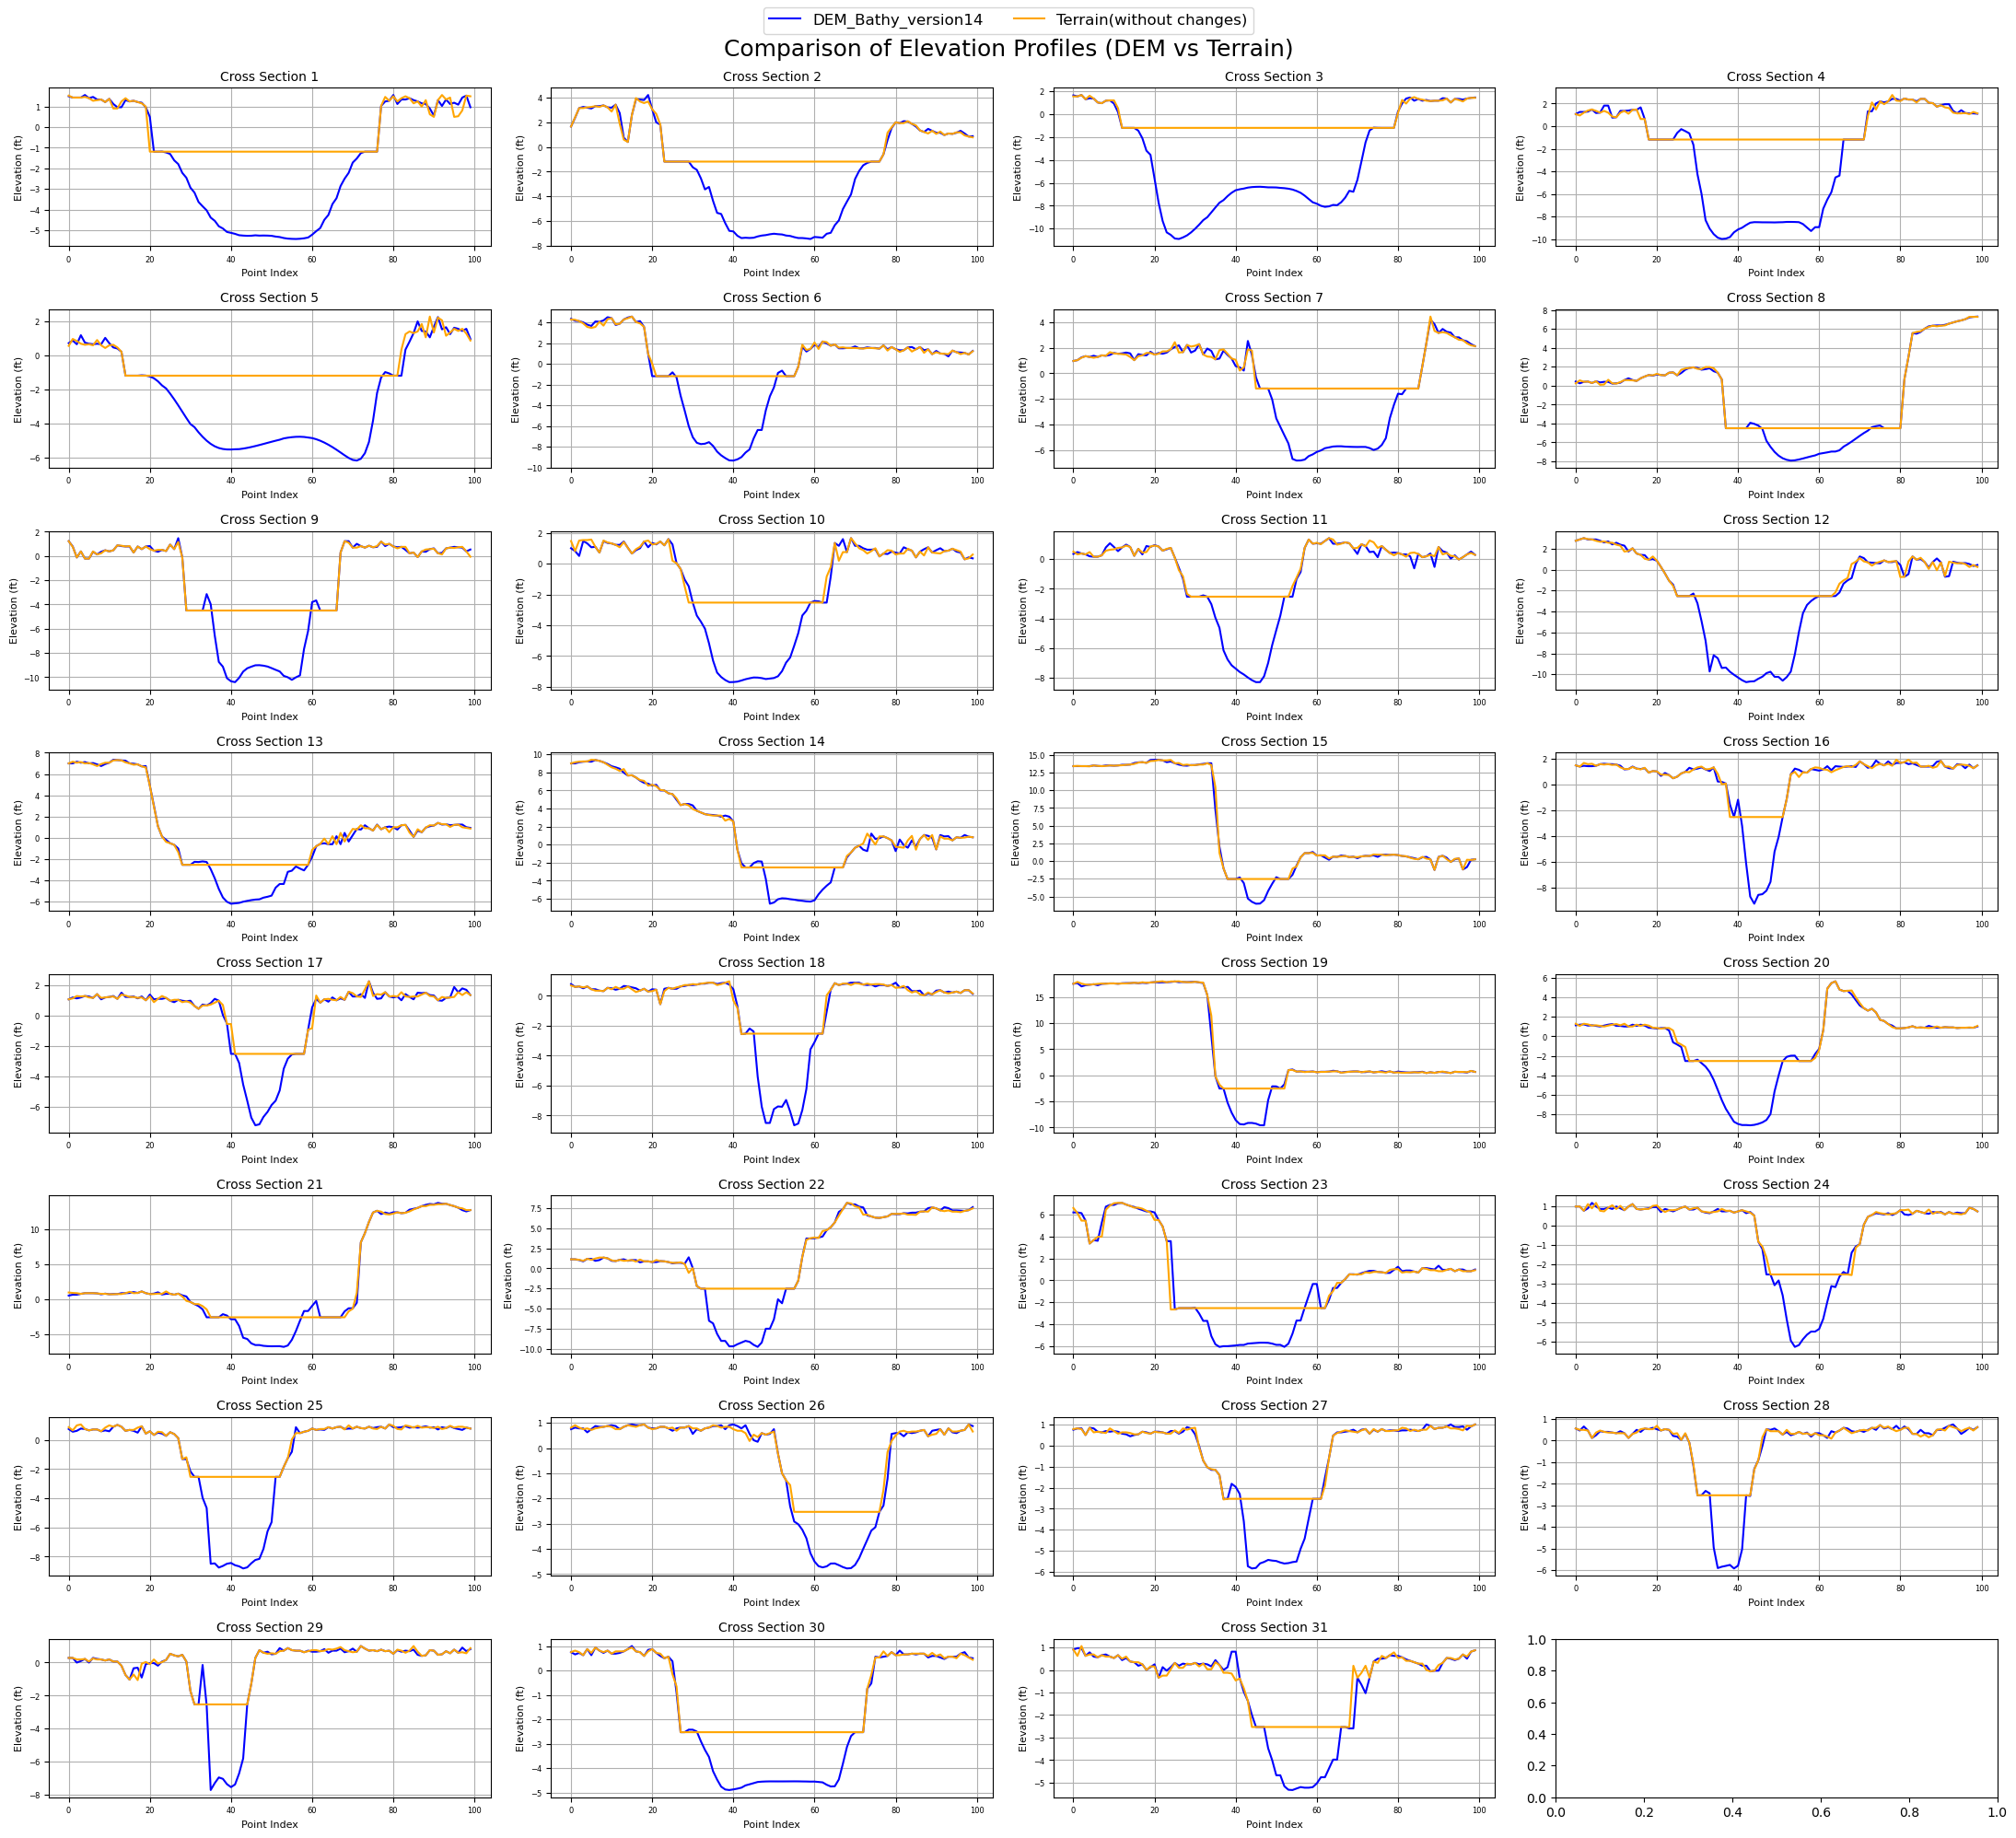

In [112]:
## DEM Bathymetry version 10
#INPUT PATHS
lines_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Cross.shp"
dem_bathy_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Moisac14.tif"
terrain_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Terrain.MD_DEMVoidFIll.tif"

#LOAD DATA
lines_gdf = gpd.read_file(lines_path)
dem_bathy = rasterio.open(dem_bathy_path)
terrain_dem = rasterio.open(terrain_path)

#FUNCTION: Sample Points Along Line
def interpolate_line(line, num_points=100):
    distances = np.linspace(0, line.length, num=num_points)
    return [line.interpolate(d) for d in distances]

#SET UP GRID PLOT
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(22, 20))
axes = axes.flatten()

#LOOP OVER EACH LINE
for idx, row in lines_gdf.iterrows():
    if idx >= len(axes):
        break

    ax = axes[idx]
    line = row.geometry
    points = interpolate_line(line, num_points=100)
    coords = [(pt.x, pt.y) for pt in points]

    # Sample elevation from both DEMs
    elev_bathy = [val[0] for val in dem_bathy.sample(coords)]
    elev_terrain = [val[0] for val in terrain_dem.sample(coords)]

    # Plot comparison
    ax.plot(elev_bathy, label='DEM_Bathy_version14', color='blue')
    ax.plot(elev_terrain, label='Terrain(without changes)', color='orange')
    ax.set_title(f"Cross Section {idx + 1}", fontsize=10)
    ax.set_ylabel("Elevation (ft)", fontsize=8)
    ax.set_xlabel("Point Index", fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.grid(True)

#FORMAT LEGEND & LAYOUT
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize='large')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Comparison of Elevation Profiles (DEM vs Terrain)", fontsize=18)
plt.show()

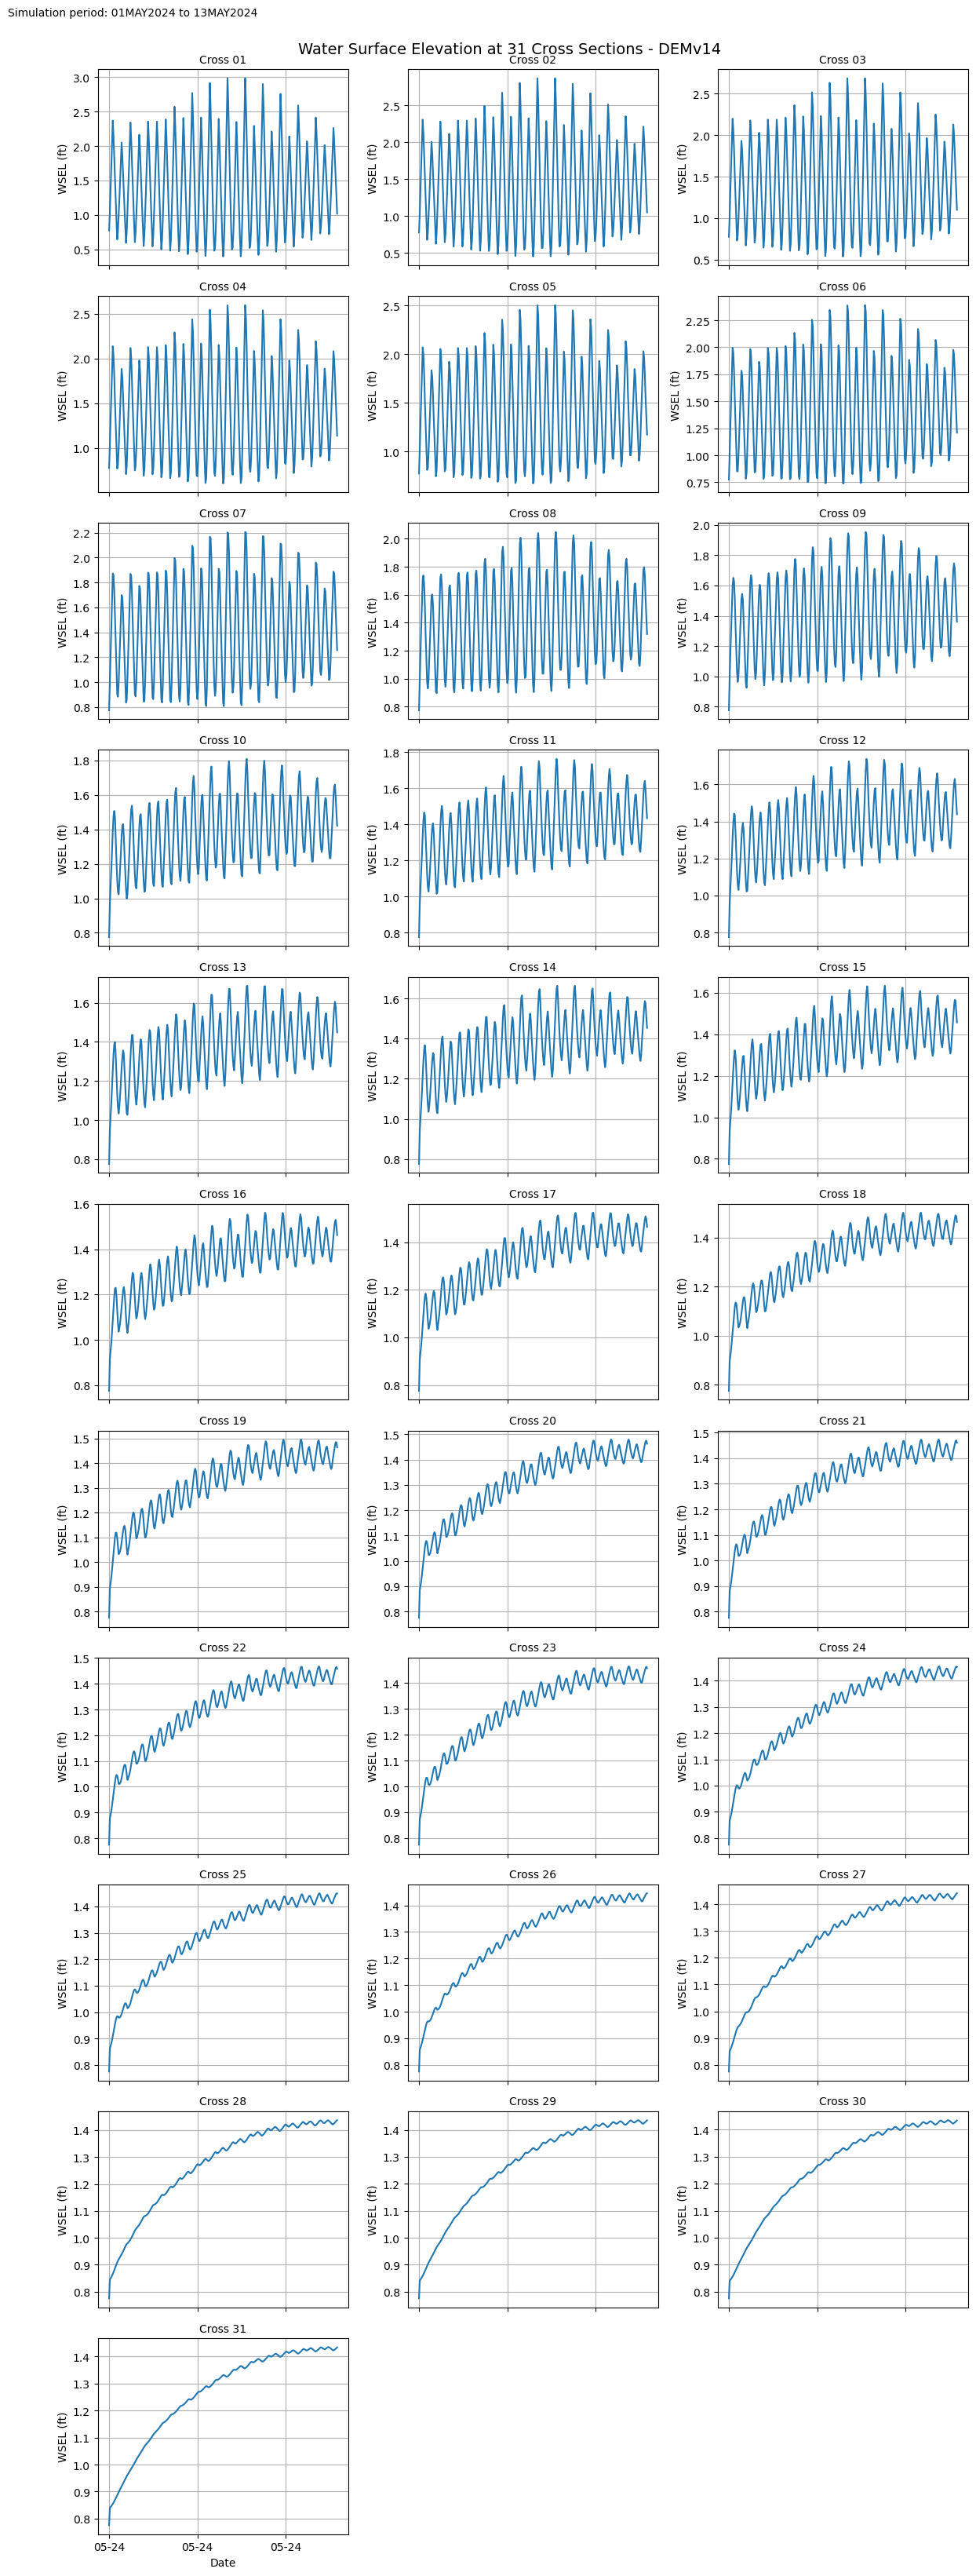

In [6]:
## Tides Simulation (WSEL) at 31 Cross Sections (DEM 14)
# FILES INPUTS
hdf_path = r'C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\HDF\v5.p70.hdf'
cell_ids = [628120, 627951, 627921, 628029, 627746, 627684, 627618, 627572, 627530, 627472, 627396, 627381, 635980, 635128, 636050, 635000, 634940, 627311, 634847, 636360, 694557, 845840, 827923, 814408, 660900, 647501, 634688, 634563, 636676, 627066, 634263]  # Replace with your actual cell IDs

# OPEN HDF FILE
with h5py.File(hdf_path, 'r') as f:
    # 1. Get time info
    time_minutes = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time'][:]
    start_str = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time Date Stamp'][0].decode()
    start_datetime = datetime.strptime(start_str, '%d%b%Y %H:%M:%S')
    time_index = [start_datetime + timedelta(minutes=float(t)) for t in time_minutes]

    # 2. Get full water surface matrix (time_steps x num_cells)
    ws_all = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/VA20230620195713/Water Surface'][:]

    # 3. Get all cell minimum elevations
    z_all = f['/Geometry/2D Flow Areas/VA20230620195713/Cells Minimum Elevation'][:]

    # 4. Build WSEL  dataframe
    wsel_data = {}
    for cid in cell_ids:
        ws = ws_all[:, cid]
        wsel_data[f'Cell_{cid}'] = ws

# CREATE FINAL DATAFRAME
wsel_df = pd.DataFrame(wsel_data, index=pd.to_datetime(time_index))
wsel_df.index.name = 'Datetime'


#Mapping Cell ID → Cross Section Name
cell_to_cross = {
    628120: "Cross 01",
    627951: "Cross 02",
    627921: "Cross 03",
    628029: "Cross 04",
    627746: "Cross 05",
    627684: "Cross 06",
    627618: "Cross 07",
    627572: "Cross 08",
    627530: "Cross 09",
    627472: "Cross 10",
    627396: "Cross 11",
    627381: "Cross 12",
    635980: "Cross 13",
    635128: "Cross 14",
    636050: "Cross 15",
    635000: "Cross 16",
    634940: "Cross 17",
    627311: "Cross 18",
    634847: "Cross 19",
    636360: "Cross 20",
    694557: "Cross 21",
    845840: "Cross 22",
    827923: "Cross 23",
    814408: "Cross 24",
    660900: "Cross 25",
    647501: "Cross 26",
    634688: "Cross 27",
    634563: "Cross 28",
    636676: "Cross 29",
    627066: "Cross 30",
    634263: "Cross 31"
}

#Prepare Grid
num_cells = len(wsel_df.columns)
cols = 3  # Number of columns for subplots
rows = math.ceil(num_cells / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True)
axes = axes.flatten()

#Plot with Custom Titles
for i, col in enumerate(wsel_df.columns):
    cell_id = int(col.replace("Cell_", ""))  # e.g., "Cell_627951" → 627951
    cross_name = cell_to_cross.get(cell_id, col)  # fallback to ID if not found

    ax = axes[i]
    ax.plot(wsel_df.index, wsel_df[col])
    ax.set_title(cross_name, fontsize=10)
    ax.set_ylabel("WSEL (ft)")
    ax.grid(True)

    # Format x-axis
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))

    if i >= (rows - 1) * cols:
        ax.set_xlabel("Date")

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Water Surface Elevation at 31 Cross Sections - DEMv14", fontsize=14)
fig.text(0.1, 0.99, "Simulation period: 01MAY2024 to 13MAY2024", ha='center', fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

## Tides Validation

Gauge: 8571359 Snow Hill, MD


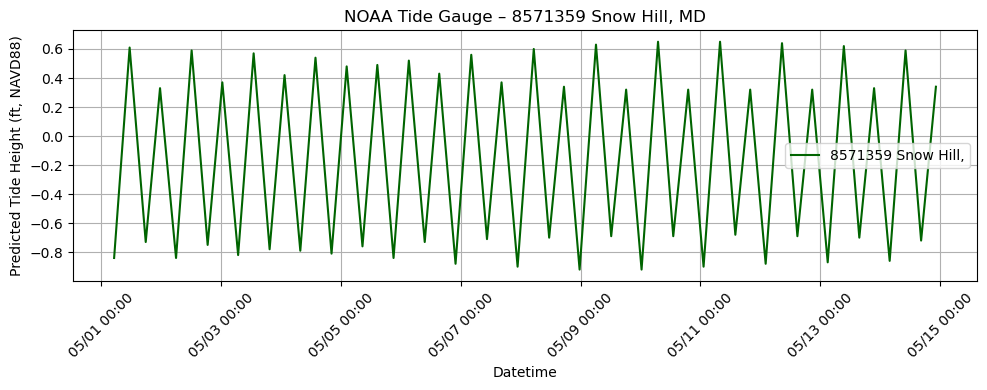

In [127]:
#Gauge plot -- Gauge 8571359 Snow Hill, MD
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === File path ===
excel_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\Book_Snowhill.xlsx"

# === Load Sheet2
df = pd.read_excel(excel_path, sheet_name="Sheet1") #check the sheet name

# === Clean column names and rename
df.columns = df.columns.str.strip().str.replace('\n', ' ', regex=True)
df.rename(columns={
    df.columns[0]: "Date",
    df.columns[1]: "Time",
    df.columns[2]: "Predicted"
}, inplace=True)

# === Combine Date + Time into single datetime column
df["Datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str), errors='coerce')
df = df.dropna(subset=["Datetime"])

# === Plot with full datetime labels
plt.figure(figsize=(10, 4))
plt.plot(df["Datetime"], df["Predicted"], label="8571359 Snow Hill,", color='darkgreen')
plt.title("NOAA Tide Gauge – 8571359 Snow Hill, MD")
plt.xlabel("Datetime")
plt.ylabel("Predicted Tide Height (ft, NAVD88)")
plt.grid(True)

# Format x-axis to show both date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.legend()
plt.show()


Snow Hill, MD Gauge Data and Shelltown, MD Gauge Data

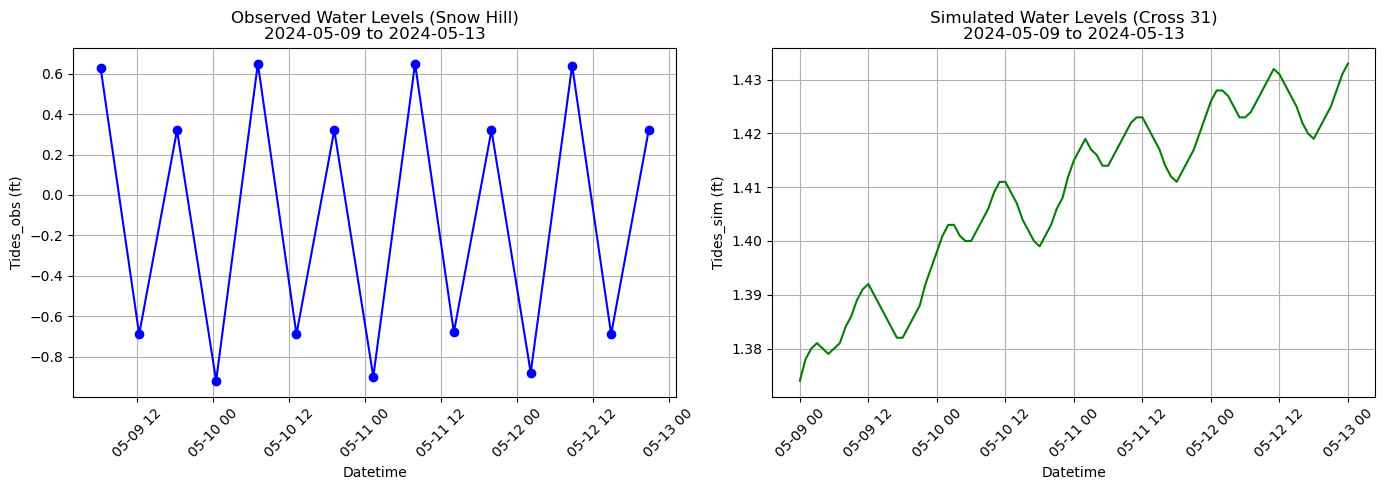

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#Load the Excel files ===
file_obs = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\Book_Snowhill.xlsx"
file_sim = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\Book_simulated_31_WSEL.xlsx"

# Load observed and simulated sheets (assuming the first sheet in each)
df_obs = pd.read_excel(file_obs)
df_sim = pd.read_excel(file_sim)

# === Convert datetime columns ===
df_obs['Datetime'] = pd.to_datetime(df_obs['Date'].astype(str) + ' ' + df_obs['Time'].astype(str))
df_sim['Datetime'] = pd.to_datetime(df_sim['Datetime'])

# === Filter data from May 9 to May 13, 2024 ===
start_date = pd.to_datetime("2024-05-09")
end_date = pd.to_datetime("2024-05-13")

df_obs_filtered = df_obs[(df_obs['Datetime'] >= start_date) & (df_obs['Datetime'] <= end_date)]
df_sim_filtered = df_sim[(df_sim['Datetime'] >= start_date) & (df_sim['Datetime'] <= end_date)]

# === Create the side-by-side plot ===
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=False)

# Plot observed data
axes[0].plot(df_obs_filtered['Datetime'], df_obs_filtered['Tides_obs (ft)'],
             color='blue', marker='o')
axes[0].set_title('Observed Water Levels (Snow Hill)\n2024-05-09 to 2024-05-13')
axes[0].set_xlabel('Datetime')
axes[0].set_ylabel('Tides_obs (ft)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# Plot simulated data
axes[1].plot(df_sim_filtered['Datetime'], df_sim_filtered['Tides_sim (ft)'],
             color='green')
axes[1].set_title('Simulated Water Levels (Cross 31)\n2024-05-09 to 2024-05-13')
axes[1].set_xlabel('Datetime')
axes[1].set_ylabel('Tides_sim (ft)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Flow validation 